In [338]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import urllib.request
import seaborn as sns
import statsmodels.api as sm
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import norm
from sklearn import preprocessing
from scipy.stats import pearsonr
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg

In [339]:
# Load All-time count of  articles (since 2017) by search terms "NYSE" and "New York Stock Exchange"
stock_news_URL = "https://api.gdeltproject.org/api/v2/doc/doc?format=json&timespan=FULL&query=(NYSE%20OR%20%22New%20York%20Stock%20Exchange%22)&mode=timelinevolraw&timezoom=yes"
with urllib.request.urlopen(stock_news_URL) as url:
    data = json.loads(url.read().decode())
    news_count_df = pd.DataFrame(data["timeline"][0]["data"])
news_count_df = news_count_df.drop([0,1,2,3])
news_count_df["date"] = pd.to_datetime(news_count_df["date"])
news_count_df.set_index('date', drop=True, inplace=True)
news_count_df.set_index(news_count_df.index.tz_localize(None), inplace=True)
news_count_df.rename(columns={'value': 'newsCount'}, inplace=True)
news_count_df

,newsCount,norm
date,,
2017-01-05,4168,830028
2017-01-06,3364,766969
2017-01-07,1848,520691
2017-01-08,1409,488784
2017-01-09,3179,813487
...,...,...
2020-03-21,910,329009
2020-03-22,350,302307
2020-03-23,1916,496911


In [340]:
# News volume intensity
stock_news_URL2 = "https://api.gdeltproject.org/api/v2/doc/doc?query=(NYSE%20or%20%22New%20York%20Stock%20Exchange%22)&mode=timelinevolinfo&TIMELINESMOOTH=5&TIMESPAN=FULL&FORMAT=json"
with urllib.request.urlopen(stock_news_URL2) as url:
    data = json.loads(url.read().decode())
    news_int_df = pd.DataFrame(data["timeline"][0]["data"])

news_int_df = news_int_df.drop(columns=['toparts'])
news_int_df["date"] = pd.to_datetime(news_int_df["date"])
news_int_df.set_index('date', drop=True, inplace=True)
news_int_df.set_index(news_int_df.index.tz_localize(None), inplace=True)
news_int_df.rename(columns={'value': 'newsInt'}, inplace=True)
news_int_df

,newsInt
date,
2017-01-05,0.3827
2017-01-06,0.4144
2017-01-07,0.4393
2017-01-08,0.4165
2017-01-09,0.3950
...,...
2020-03-21,0.4136
2020-03-22,0.3661
2020-03-23,0.3716


In [341]:
# Load stock data from https://finance.yahoo.com/quote/%5ENYA/history?period1=1486857600&period2=1584576000&interval=1d&filter=history&frequency=1d 
stock_df = pd.read_csv("^NYA.csv")
stock_df = stock_df.drop([0,1,2])
stock_df["Date"] = pd.to_datetime(stock_df["Date"], format="%Y-%m-%d")
stock_df.set_index('Date', drop=True, inplace=True)
stock_df = stock_df[['Open', 'Close']]

In [342]:
# reindex to fill missing dates and interpolate the corresponding missing values
full_idx = pd.date_range(start=stock_df.index.min(), end=stock_df.index.max(), freq='1D')
stock_df = stock_df.reindex(full_idx)
full_idx = pd.date_range(start=news_int_df.index.min(), end=news_int_df.index.max(), freq='1D')
news_int_df = news_int_df.reindex(full_idx)
full_idx = pd.date_range(start=news_count_df.index.min(), end=news_count_df.index.max(), freq='1D')
news_count_df = news_count_df.reindex(full_idx)

stock_df = stock_df.interpolate()
news_int_df = news_int_df.interpolate()
news_count_df = news_count_df.interpolate()
news_int_df.head(5)#, news_count_df.head(5)

,newsInt
2017-01-05,0.3827
2017-01-06,0.4144
2017-01-07,0.4393
2017-01-08,0.4165
2017-01-09,0.3950


In [343]:
# combine the datasets
df = stock_df.join(news_count_df, how='inner')
df = df.join(news_int_df, how='inner')
df.head(5)

,Open,Close,newsCount,norm,newsInt
2017-02-16,11519.320313,11504.190430,4124.0,899621.0,0.3692
2017-02-17,11468.009766,11510.910156,3957.0,845037.0,0.4159
2017-02-18,11480.492432,11527.745117,1853.0,546303.0,0.4130
2017-02-19,11492.975098,11544.580078,1040.0,492129.0,0.3757
2017-02-20,11505.457764,11561.415039,1606.0,770453.0,0.3371


,Open_diff,Close_diff,newsCount_diff,newsInt_diff,Open,Close,newsCount,norm,newsInt
2017-02-17,-51.310547,6.719726,-167.0,0.0467,11468.009766,11510.910156,3957.0,845037.0,0.4159
2017-02-18,12.482666,16.834961,-2104.0,-0.0029,11480.492432,11527.745117,1853.0,546303.0,0.4130
2017-02-19,12.482666,16.834961,-813.0,-0.0373,11492.975098,11544.580078,1040.0,492129.0,0.3757
2017-02-20,12.482666,16.834961,566.0,-0.0386,11505.457764,11561.415039,1606.0,770453.0,0.3371
2017-02-21,12.482666,16.834961,1342.0,-0.0234,11517.940430,11578.250000,2948.0,863510.0,0.3137
...,...,...,...,...,...,...,...,...,...
2020-03-14,135.513346,-428.069987,-1184.0,-0.0677,10580.953776,10423.670247,660.0,314890.0,0.3608
2020-03-15,135.513346,-428.069987,-291.0,-0.0635,10716.467123,9995.600260,369.0,303076.0,0.2973
2020-03-16,135.513346,-428.069987,1629.0,0.0221,10851.980469,9567.530273,1998.0,494418.0,0.3194
2020-03-17,-1125.800781,495.830079,-129.0,-0.0282,9726.179688,10063.360352,1869.0,528913.0,0.2912


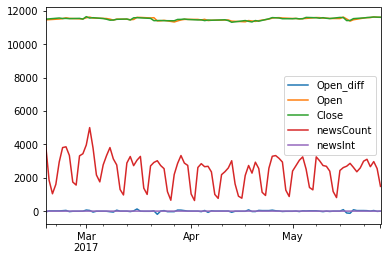

In [344]:
df = df[['Open', 'Close', 'newsCount', 'newsInt']].diff().dropna().join(df, lsuffix = '_diff')
df[['Open_diff','Open', 'Close', 'newsCount', 'newsInt']].head(100).plot()
df

,Close_pos_diff,Close_neg_diff,Open_pos_diff,Open_neg_diff,Open_diff,Close_diff,newsCount_diff,newsInt_diff,Open,Close,newsCount,norm,newsInt
2017-02-17,6.719726,0.000000,0.000000,-51.310547,-51.310547,6.719726,-167.0,0.0467,11468.009766,11510.910156,3957.0,845037.0,0.4159
2017-02-18,16.834961,0.000000,12.482666,0.000000,12.482666,16.834961,-2104.0,-0.0029,11480.492432,11527.745117,1853.0,546303.0,0.4130
2017-02-19,16.834961,0.000000,12.482666,0.000000,12.482666,16.834961,-813.0,-0.0373,11492.975098,11544.580078,1040.0,492129.0,0.3757
2017-02-20,16.834961,0.000000,12.482666,0.000000,12.482666,16.834961,566.0,-0.0386,11505.457764,11561.415039,1606.0,770453.0,0.3371
2017-02-21,16.834961,0.000000,12.482666,0.000000,12.482666,16.834961,1342.0,-0.0234,11517.940430,11578.250000,2948.0,863510.0,0.3137
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-14,0.000000,-428.069987,135.513346,0.000000,135.513346,-428.069987,-1184.0,-0.0677,10580.953776,10423.670247,660.0,314890.0,0.3608
2020-03-15,0.000000,-428.069987,135.513346,0.000000,135.513346,-428.069987,-291.0,-0.0635,10716.467123,9995.600260,369.0,303076.0,0.2973
2020-03-16,0.000000,-428.069987,135.513346,0.000000,135.513346,-428.069987,1629.0,0.0221,10851.980469,9567.530273,1998.0,494418.0,0.3194
2020-03-17,495.830079,0.000000,0.000000,-1125.800781,-1125.800781,495.830079,-129.0,-0.0282,9726.179688,10063.360352,1869.0,528913.0,0.2912


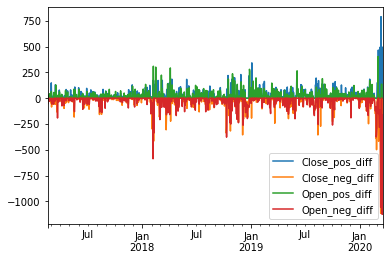

In [345]:
pos = df[df['Open_diff']>=0][['Open_diff']].rename(columns={"Open_diff": "Open_pos_diff"})
neg = df[df['Open_diff']<0][['Open_diff']].rename(columns={"Open_diff": "Open_neg_diff"})
df_pos_neg_open = pos.join(neg, how='outer').fillna(0).join(df)
pos = df[df['Close_diff']>=0][['Close_diff']].rename(columns={"Close_diff": "Close_pos_diff"})
neg = df[df['Close_diff']<0][['Close_diff']].rename(columns={"Close_diff": "Close_neg_diff"})
df = pos.join(neg, how='outer').fillna(0).join(df_pos_neg_open)
df[['Close_pos_diff','Close_neg_diff', 'Open_pos_diff','Open_neg_diff']].plot()
df

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002090BF96508>]],
      dtype=object)

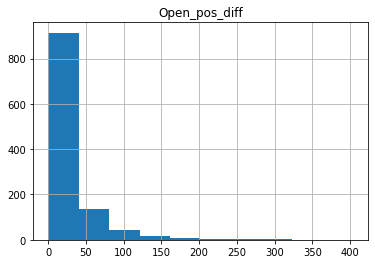

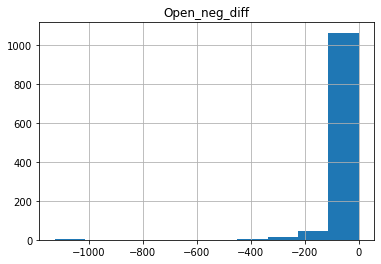

In [346]:
df[['Open_pos_diff']].hist()
df[['Open_neg_diff']].hist()

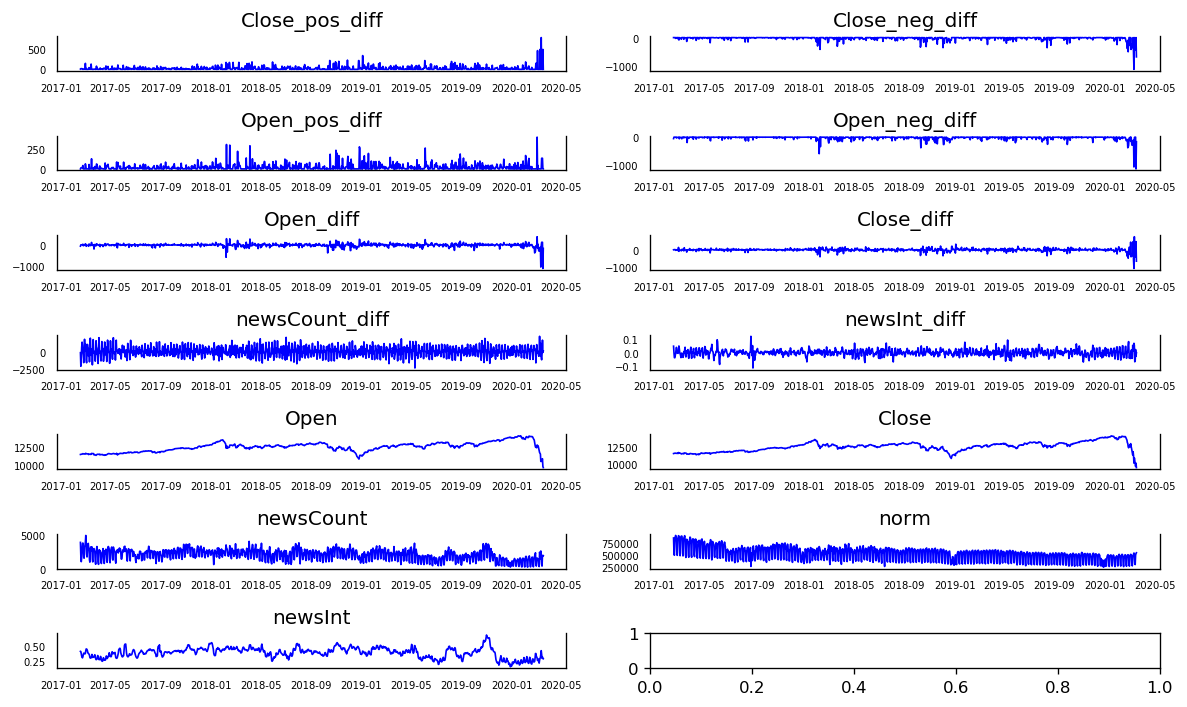

In [347]:
fig, axes = plt.subplots(nrows=7, ncols=2, dpi=120, figsize=(10,6))
for i, col in enumerate(df.columns):
    ax = axes.flatten()[i]
    data = df[df.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Open, Close show some trends/seasonality.

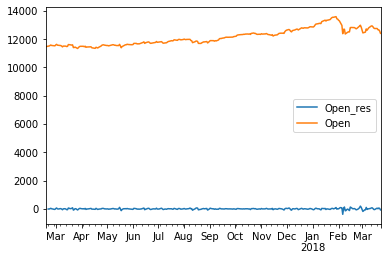

In [348]:
# remove Open/Close trends and seasonality
df = df.asfreq('D')
res_close = sm.tsa.seasonal_decompose(df['Close'])
res_open = sm.tsa.seasonal_decompose(df['Open'])
#resplot = res_news.plot()
df['Open_res'] = df['Open'] - res_open.trend
df['Close_res'] = df['Open'] - res_close.trend
df[['Open_res', 'Open']].head(400).plot()
df = df.dropna() # Close_res and Open_res have 6 Nan values (3 in the beginning and 3 in the end)

In [349]:
# Doing the Augemented Dickey-Fuller test to see how strongly a time-series is defined by a trend. if p<0.05, 
# then the null hypothesis that the time series is non-stationary fails to be rejected. Else the series is stationary.
# Ref 
for col in ['newsCount', 'newsCount_diff', 'Open_diff', 'Close_diff', 'newsInt', 'Open_pos_diff', 'Open_neg_diff', 'Close_pos_diff', 'Close_neg_diff']:
    result = adfuller(df[[col]], autolag='BIC')
    print(f"\n Testing ADf for {col}")
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'nlags: {result[2]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


 Testing ADf for newsCount
ADF Statistic: -3.9321230841629284
p-value: 0.00181075435472418
nlags: 15
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568

 Testing ADf for newsCount_diff
ADF Statistic: -10.634362047977753
p-value: 5.117421094441249e-19
nlags: 14
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568

 Testing ADf for Open_diff
ADF Statistic: -19.774110874985478
p-value: 0.0
nlags: 1
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568

 Testing ADf for Close_diff
ADF Statistic: -7.753847751398636
p-value: 9.856671169765807e-12
nlags: 8
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568

 Testing ADf for newsInt
ADF Statistic: -3.7927400793577517
p-value: 0.002982473020426258
nlags: 20
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568

 Testing ADf for Open_pos_diff
ADF Statistic: -29.886304597484557
p-value: 0.0
nlags: 0
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568

 Testing ADf for Open_neg_diff
ADF Statistic: -13.840465089583862
p-value: 7.308743046

Notes: 
With AIC:Open, Close,Open_neg_diff, Close_neg_diff are non-stationary. Open_diff, close_diff, newsCount, newsInt, Open_res, Close_res, Open_pos_diff and Close_pos_diff are stationary.
With BIC: Close_neg_diff not stationary. Others are.

In [350]:
# Testing for causality of each time series' past values on the other (Ref https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/)
maxlag=5
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            best_lag = np.argmin(p_values)
            if verbose: print(f'Y = {r}, X = {c}, best_lag = {best_lag}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns, verbose=True)  

Y = Close_pos_diff, X = Close_pos_diff, best_lag = 0, P Values = [1.0, 1.0, 1.0, 1.0, 1.0]
Y = Close_neg_diff, X = Close_pos_diff, best_lag = 0, P Values = [0.0, 0.0, 0.0, 0.0, 0.0]
Y = Open_pos_diff, X = Close_pos_diff, best_lag = 0, P Values = [0.0, 0.0, 0.0, 0.0, 0.0]
Y = Open_neg_diff, X = Close_pos_diff, best_lag = 0, P Values = [0.0, 0.0, 0.0, 0.0, 0.0]
Y = Open_diff, X = Close_pos_diff, best_lag = 0, P Values = [0.0, 0.0, 0.0, 0.0, 0.0]
Y = Close_diff, X = Close_pos_diff, best_lag = 0, P Values = [0.0, 0.0, 0.0, 0.0, 0.0]
Y = newsCount_diff, X = Close_pos_diff, best_lag = 0, P Values = [0.0, 0.0001, 0.0, 0.0008, 0.3257]
Y = newsInt_diff, X = Close_pos_diff, best_lag = 3, P Values = [0.5751, 0.7872, 0.2728, 0.0, 0.0]
Y = Open, X = Close_pos_diff, best_lag = 0, P Values = [0.0, 0.0, 0.0, 0.0, 0.0]
Y = Close, X = Close_pos_diff, best_lag = 1, P Values = [0.0003, 0.0, 0.0, 0.0, 0.0]
Y = newsCount, X = Close_pos_diff, best_lag = 0, P Values = [0.0, 0.0, 0.0, 0.0, 0.0001]
Y = norm, X 

Y = Close_neg_diff, X = newsCount_diff, best_lag = 3, P Values = [0.1797, 0.1557, 0.0002, 0.0, 0.0]
Y = Open_pos_diff, X = newsCount_diff, best_lag = 0, P Values = [0.0, 0.0, 0.0, 0.0, 0.0]
Y = Open_neg_diff, X = newsCount_diff, best_lag = 2, P Values = [0.0182, 0.0025, 0.0, 0.0, 0.0]
Y = Open_diff, X = newsCount_diff, best_lag = 4, P Values = [0.4627, 0.7037, 0.2792, 0.3712, 0.1211]
Y = Close_diff, X = newsCount_diff, best_lag = 0, P Values = [0.0196, 0.0672, 0.0583, 0.0292, 0.0467]
Y = newsCount_diff, X = newsCount_diff, best_lag = 0, P Values = [1.0, 1.0, 1.0, 1.0, 1.0]
Y = newsInt_diff, X = newsCount_diff, best_lag = 0, P Values = [0.0, 0.0, 0.0, 0.0, 0.0]
Y = Open, X = newsCount_diff, best_lag = 4, P Values = [0.6413, 0.6141, 0.2332, 0.3693, 0.1274]
Y = Close, X = newsCount_diff, best_lag = 0, P Values = [0.0199, 0.0649, 0.0428, 0.03, 0.0479]
Y = newsCount, X = newsCount_diff, best_lag = 0, P Values = [0.0, 0.0, 0.9991, 0.0, 0.0]
Y = norm, X = newsCount_diff, best_lag = 0, P Value

Y = norm, X = newsInt, best_lag = 1, P Values = [0.0649, 0.0, 0.0, 0.0, 0.0]
Y = newsInt, X = newsInt, best_lag = 0, P Values = [1.0, 1.0, 1.0, 1.0, 1.0]
Y = Open_res, X = newsInt, best_lag = 4, P Values = [0.6366, 0.617, 0.3209, 0.1121, 0.0712]
Y = Close_res, X = newsInt, best_lag = 4, P Values = [0.446, 0.6914, 0.845, 0.7963, 0.1503]
Y = Close_pos_diff, X = Open_res, best_lag = 0, P Values = [0.0, 0.0, 0.0, 0.0, 0.0]
Y = Close_neg_diff, X = Open_res, best_lag = 0, P Values = [0.0, 0.0, 0.0, 0.0, 0.0]
Y = Open_pos_diff, X = Open_res, best_lag = 0, P Values = [0.0, 0.0, 0.0, 0.0, 0.0]
Y = Open_neg_diff, X = Open_res, best_lag = 0, P Values = [0.0, 0.0, 0.0, 0.0, 0.0]
Y = Open_diff, X = Open_res, best_lag = 0, P Values = [0.0, 0.0, 0.0, 0.0, 0.0]
Y = Close_diff, X = Open_res, best_lag = 0, P Values = [0.0, 0.0, 0.0, 0.0, 0.0]
Y = newsCount_diff, X = Open_res, best_lag = 1, P Values = [0.0549, 0.0505, 0.084, 0.1939, 0.1863]
Y = newsInt_diff, X = Open_res, best_lag = 1, P Values = [0.2229

,Close_pos_diff_x,Close_neg_diff_x,Open_pos_diff_x,Open_neg_diff_x,Open_diff_x,Close_diff_x,newsCount_diff_x,newsInt_diff_x,Open_x,Close_x,newsCount_x,norm_x,newsInt_x,Open_res_x,Close_res_x
Close_pos_diff_y,1.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Close_neg_diff_y,0.0,1.0000,0.0945,0.0000,0.0001,0.0000,0.0000,0.0064,0.0089,0.0000,0.0000,0.0000,0.0198,0.0000,0.0000
Open_pos_diff_y,0.0,0.0000,1.0000,0.0002,0.0002,0.0000,0.0000,0.0029,0.0037,0.0000,0.0000,0.0000,0.0080,0.0000,0.0000
Open_neg_diff_y,0.0,0.0000,0.7404,1.0000,0.7404,0.0000,0.0000,0.0305,0.1377,0.0000,0.0000,0.0000,0.0271,0.0000,0.0000
Open_diff_y,0.0,0.0000,0.1923,0.1923,1.0000,0.0000,0.1211,0.0441,0.0760,0.0000,0.1976,0.6572,0.0508,0.0000,0.0000
Close_diff_y,0.0,0.0000,0.0020,0.0000,0.0000,1.0000,0.0196,0.0172,0.2999,0.3527,0.0364,0.2949,0.0200,0.0000,0.0000
newsCount_diff_y,0.0,0.0001,0.0000,0.0000,0.3537,0.0516,1.0000,0.0000,0.5472,0.1536,0.0000,0.0000,0.0000,0.0505,0.1911
newsInt_diff_y,0.0,0.0001,0.0000,0.0003,0.0296,0.0049,0.0000,1.0000,0.1324,0.0262,0.0000,0.0000,0.0000,0.0139,0.0063
Open_y,0.0,0.0000,0.0020,0.0000,0.0000,0.0000,0.1274,0.0446,1.0000,0.0000,0.3749,0.7331,0.0754,0.0000,0.0000
Close_y,0.0,0.0000,0.0032,0.0000,0.0000,0.0000,0.0199,0.0172,0.0000,1.0000,0.0512,0.2082,0.0195,0.0000,0.0000


1. X = {Open_diff} causes Y={newsInt_diff} at best lag 0
2. X = {Close_diff} causes Y={newsInt_diff} at best lag 0
3. X = {Open_diff} causes Y={newsInt} at best lag 0
4. X = {Close_diff} causes Y={newsInt} at best lag 0
4. X = {Open/Close_pos/neg_diff} causes Y = {newsInt, newsInt_diff, newsCount,newsCount_diff}

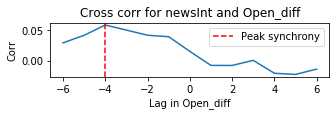

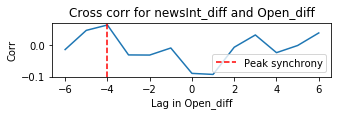

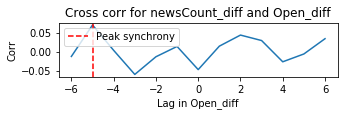

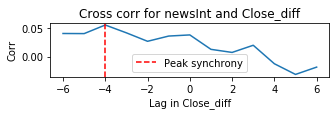

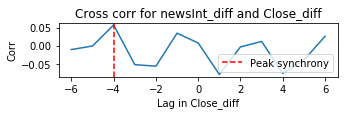

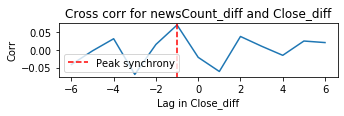

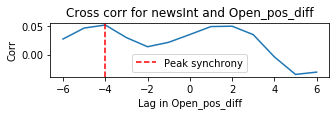

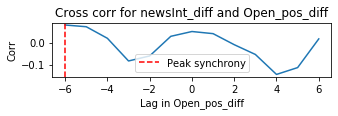

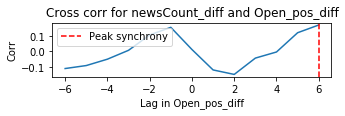

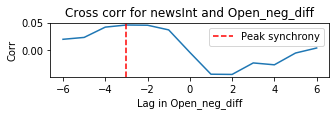

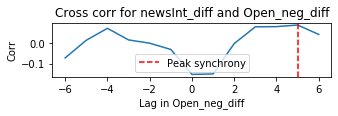

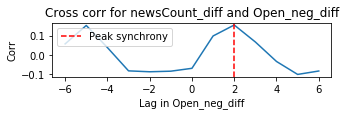

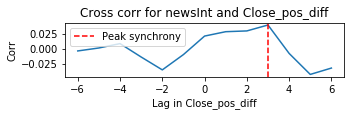

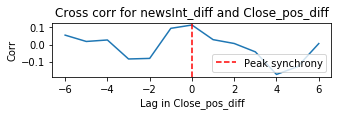

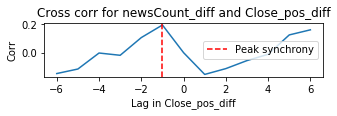

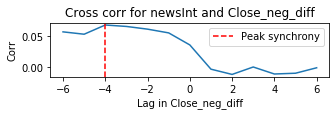

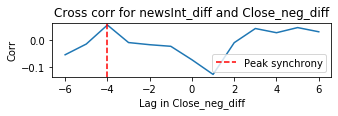

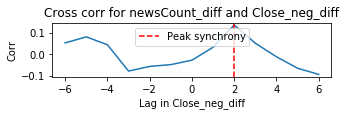

In [351]:
#### TIME LAGGED CORRELATION ref [https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9]
def crosscorr(datax, datay, lag=0, wrap=False, toprint=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0 lag in datay compared to datax
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        shiftedy = datay.shift(lag)  
        corr = datax.corr(shiftedy)
        if toprint:
            plt.subplots(figsize=(10,2))
            plt.plot(datax.head(45).index, datax.head(45), label=datax.name)
            plt.xticks(rotation=90)
            plt.legend()
            plt.subplots(figsize=(10,2))
            plt.plot(shiftedy.head(45).index, shiftedy.head(45), label=datay.name)
            plt.xticks(rotation=90)
            plt.legend()
            plt.show()
            print(f"Corr = {corr} for lag {lag}")
        return corr

def max_synchrony(d1, d2, lag_range):
    rs = [crosscorr(d1,d2, lag, toprint=False) for lag in range(-int(lag_range),int(lag_range+1))]
    offset = np.ceil(len(rs)/2)-np.argmax(rs)
    f,ax=plt.subplots(figsize=(5,1))
    ax.plot(np.arange(-int(lag_range),int(lag_range+1)), rs)
    ax.axvline(np.argmax(rs)-lag_range,color='r',linestyle='--',label='Peak synchrony')
    ax.set_xlabel(f"Lag in {stock_label}")
    ax.set_ylabel("Corr")
    ax.set_title(f"Cross corr for {news_label} and {stock_label}")
    plt.legend()

for stock_label in ['Open_diff', 'Close_diff', 'Open_pos_diff', 'Open_neg_diff', 'Close_pos_diff', 'Close_neg_diff']:
    for news_label in ['newsInt', 'newsInt_diff', 'newsCount_diff']:
        max_synchrony(df[news_label], df[stock_label], 6)

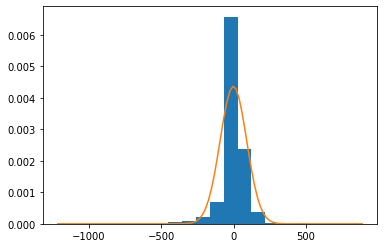

-1.3830176946428554 91.36457016649643


In [352]:
stock_label = 'Close_diff'
news_label = 'newsCount_diff'

plt.hist(df[stock_label].to_numpy(), bins = 20, density=True) 
mean,std = norm.fit(df[stock_label].to_numpy())
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y)
plt.show()
print(mean, std)

In [353]:
stock_label = 'Open_diff'
news_label = 'newsCount'

def pearson_pvalues(x):
    if len(x) < 2:
        return np.nan
    return pearsonr(x[stock_label], x[news_label])[1]

def subsample(diff, label):
    '''
    randomly and uniformly subsample
    '''
    neg_len = len(diff[diff[label]<=0].dropna())
    pos_len = len(diff[diff[label]>0].dropna())
    pos_idx = diff[diff[label]>0].dropna().index
    neg_idx = diff[diff[label]<=0].dropna().index
    if neg_len<pos_len:
        pos_idx = pd.Index(np.random.choice(pos_idx, neg_len, replace=False))
    else:
        if pos_len<neg_len:
            neg_idx = pd.Index(np.random.choice(neg_idx, pos_len, replace=False))
    return diff.loc[pos_idx.union(neg_idx)]

num_std = 3
stock_diff = df[[stock_label]]
mean,std = norm.fit(stock_diff.to_numpy())

st = stock_diff[(stock_diff<= mean+(num_std*std)) & (stock_diff >= mean-(num_std*std))].dropna()
st = subsample(st, label=stock_label)
joint_diff = st.join(df[[news_label]])
ranges = [math.floor(joint_diff[stock_label].min()), 0, math.ceil(joint_diff[stock_label].max())+1]
groups = joint_diff.groupby(pd.cut(joint_diff[stock_label], ranges))[[stock_label, news_label]]
corrs = groups.corr().dropna()
pvals = groups.apply(pearson_pvalues).dropna() # p-values
avgNewsCount = groups.agg({news_label: "sum"}).dropna()
count = groups.count()
corrs, pvals, avgNewsCount, count

(                     Open_diff  newsCount
 Open_diff                                
 (-208, 0] Open_diff   1.000000  -0.209680
           newsCount  -0.209680   1.000000
 (0, 225]  Open_diff   1.000000   0.173214
           newsCount   0.173214   1.000000, Open_diff
 (-208, 0]    0.000003
 (0, 225]     0.000132
 dtype: float64,               newsCount              
               Open_diff     newsCount
 Open_diff                            
 (-208, 0] -19431.762688  1.000430e+06
 (0, 225]   16859.872475  1.003194e+06,            Open_diff  newsCount
 Open_diff                      
 (-208, 0]        482        482
 (0, 225]         482        482)

#### VAR Modelling

In [376]:
i = 0
results = []
for y_label in ['newsCount_diff', 'newsInt_diff']: # , 'newsCount','newsInt']:
    for x_label in ['Open_pos_diff', 'Open_neg_diff']: #, 'Close_pos_diff', 'Close_neg_diff']:
        model = VAR(df[[x_label, y_label]])
        result = model.fit(ic='bic', verbose=False)
        results.append(result)
        params = result.params[y_label]
        params = params[params.index.str.contains(x_label)].rename('Coeffs')
        idx = params.abs().sort_values(ascending=False).head(5).index
        pvalues = result.pvalues[y_label][idx].rename('p-values')
        print(f"Results {i} for {x_label}-> {y_label}")
        print(f"Correlation matrix of residuals: \n\n  {x_label}  {y_label} \n {result.resid_corr}")
        print(pd.concat([params[idx], pvalues], axis=1))
        print(f"\n Coeff sum = {params.sum()}")
        print("=====================================\n\n")
        i += 1

Results 0 for Open_pos_diff-> newsCount_diff
Correlation matrix of residuals: 

  Open_pos_diff  newsCount_diff 
 [[1.         0.04773455]
 [0.04773455 1.        ]]
                    Coeffs  p-values
L2.Open_pos_diff -0.677143  0.027387
L4.Open_pos_diff -0.595694  0.053249
L6.Open_pos_diff  0.467042  0.130480
L7.Open_pos_diff  0.345810  0.262369
L1.Open_pos_diff  0.203814  0.503985

 Coeff sum = -0.5287569405058106


Results 1 for Open_neg_diff-> newsCount_diff
Correlation matrix of residuals: 

  Open_neg_diff  newsCount_diff 
 [[ 1.         -0.12921728]
 [-0.12921728  1.        ]]
                     Coeffs  p-values
L7.Open_neg_diff   0.781164  0.001920
L14.Open_neg_diff -0.496823  0.047183
L11.Open_neg_diff -0.413430  0.104275
L10.Open_neg_diff  0.384917  0.129361
L3.Open_neg_diff   0.258679  0.214969

 Coeff sum = 0.3936048989158821


Results 2 for Open_pos_diff-> newsInt_diff
Correlation matrix of residuals: 

  Open_pos_diff  newsInt_diff 
 [[1.         0.01101105]
 [0.011011

1. Correlation of residuals are very low for Open_pos_diff & newsInt,Open_pos_diff & newsInt_diff, Close_pos_diff& newsCount_diff
2. Coeff values are very low for Close_pos_diff & newsInt_diff, Close_pos_diff & newsInt, Open_pos_diff & newsInt_diff, Open_pos_diff & newsInt
What's left: Open_pos_diff &  newsCount (result0), Open_pos_diff & newsCount_diff (result1), Close_pos_diff & newsCount (result4)
2. Only first coeff is significant for Open_pos_diff & newsCount and Close_pos_diff & newsCount . Two coeffs are significant for Open_pos_diff & newsCount_diff. 

##### Impulse Response Analysis

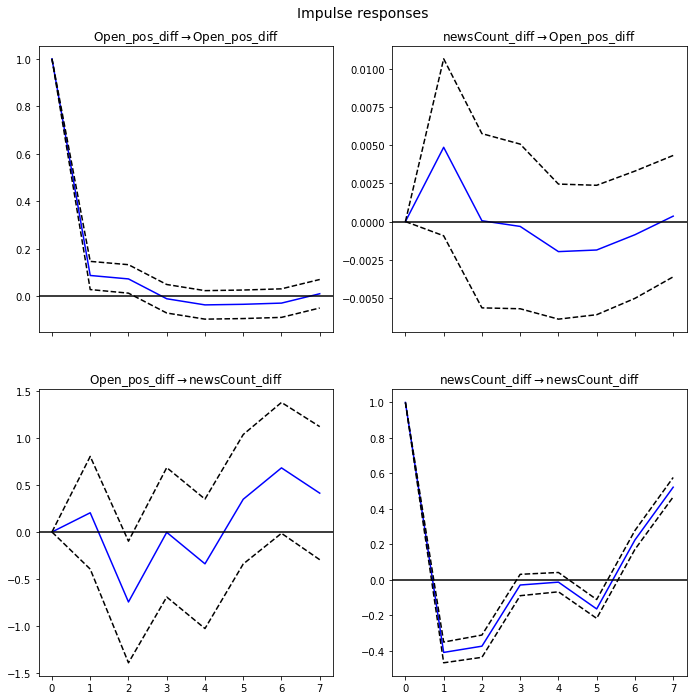

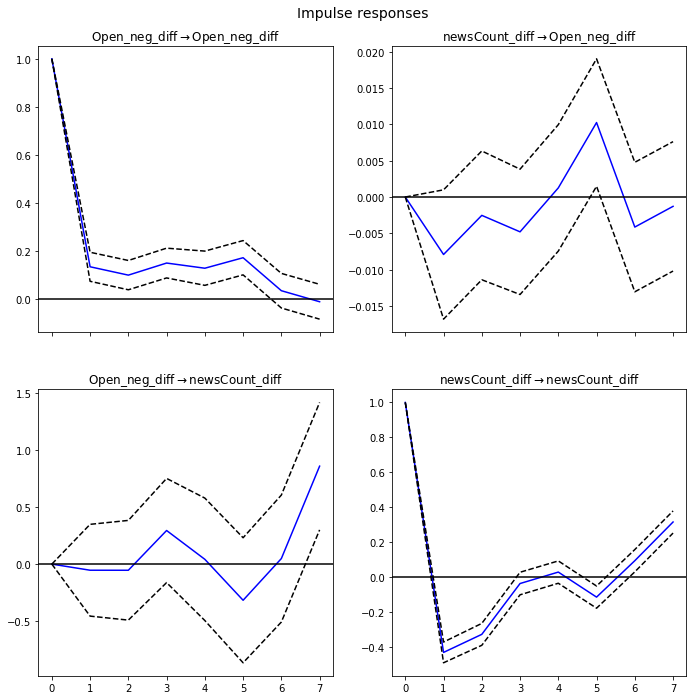

In [377]:
irf1 = results[0].irf(7)
irf1.plot(orth=False) #, impulse='Close_pos_diff', response='newsInt_diff')
irf2 = results[1].irf(7)
irf2.plot(orth=False) #,impulse='Close_neg_diff', response='newsInt_diff')
a = 6 # to prevent printing the graphs twice

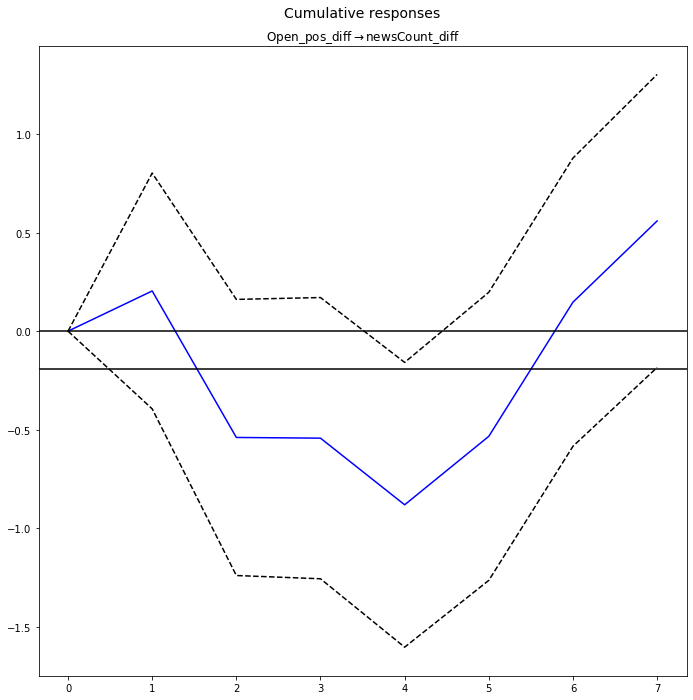

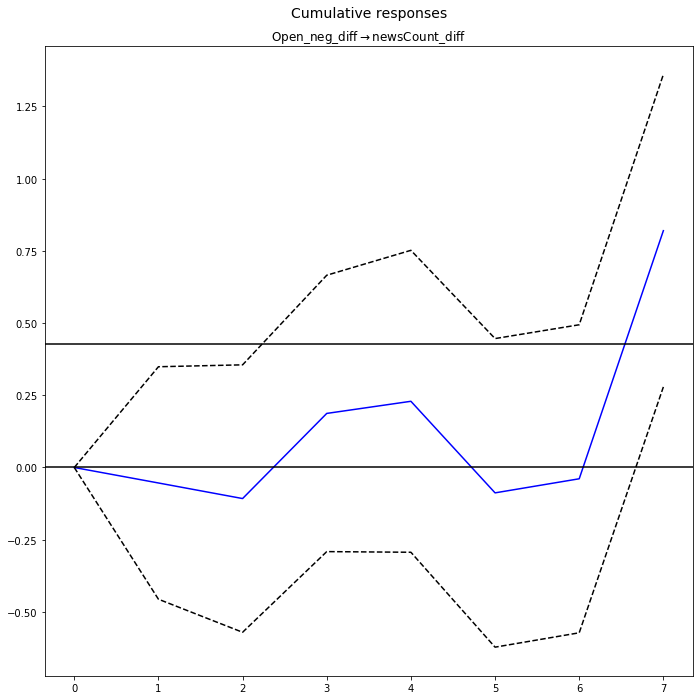

In [378]:
irf1.plot_cum_effects(orth=False, impulse='Open_pos_diff', response='newsCount_diff')
irf2.plot_cum_effects(orth=False, impulse='Open_neg_diff', response='newsCount_diff')
a = 7